In [1]:
# !pip install git+https://github.com/howl-anderson/tf_crf_layer.git\


In [2]:
# import zipfile
# with zipfile.ZipFile("processed-data-labeled.zip","r") as zip_ref:
#     zip_ref.extractall("./")

In [3]:
from copy import deepcopy
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt
# from tf_crf_layer.layer import CRF
# from tf_crf_layer.loss import crf_loss
# from tf_crf_layer.metrics import crf_accuracy
# from tf_crf_layer.crf_static_constraint_helper import allowed_transitions

In [4]:
threshold = 0.2
hidden_size = 100
word_embedding_dim = 300
class_labels_number = 5
num_text = 5
epochs = 20

labeled_dataset_size = 1830
train_dataset_size = 900
validation_dataset_size = 100
test_dataset_size = 830
unlabeled_dataset_size = 0

pos_list = np.char.lower(["ADJ","ADP","ADV","AUX","CONJ","DET","INTJ","NOUN","NUM","PART","PRON","PROPN","PUNCT","SCONJ","SYM","VERB","X"])
dep_list = np.char.lower(["ROOT", "acl", "acomp", "advcl", "advmod", "agent", "amod", "appos", "attr", "aux", "auxpass", "case", "cc", "ccomp", "compound", "conj", "csubj", "csubjpass", "dative", "dep", "det", "dobj", "expl", "intj", "mark", "meta", "neg", "nmod", "npadvmod", "nsubj", "nsubjpass", "nummod", "oprd", "parataxis", "pcomp", "pobj", "poss", "preconj", "predet", "prep", "prt", "punct", "quantmod", "relcl", "xcomp"])

pos_dim = len(pos_list)
dep_dim = len(dep_list)

In [5]:
def one_hot(vec, dic):
    vec = np.char.lower(vec)
    return np.array([dic == row for row in vec], dtype='i1')

In [6]:
labeled_dataset = []
unlabeled_dataset = []

train_dataset = []
validation_dataset = []
test_dataset = []

for i in range(1, labeled_dataset_size + 1):
    filename = "processed-data-labeled/processed-labeled-tweet-{}.csv".format(i)
    if os.path.exists(filename):
        with open(filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            data = [tuple(x) for x in spamreader]
            data = np.array(data, dtype=([("text", 'U20'),("simplified_text", 'U20'), ("best_match", 'U20'), ("index", int), ("pos", 'U20'), ("dep", 'U20'), ("stop", 'U5'), ("label", 'i1')]))
            if len(data):
                labeled_dataset.append(data)


for i in range(len(labeled_dataset)):
    tweet = labeled_dataset[i]
    text = tf.reshape(tweet["index"], (1, -1, 1))
    pos = tf.reshape(one_hot(tweet["pos"], pos_list), (1, -1, pos_dim))
    dep = tf.reshape(one_hot(tweet["dep"], dep_list), (1, -1, dep_dim))
    label = tf.reshape(tf.one_hot(tweet["label"], 2), (1, -1, 2))
    train_dataset.append((np.concatenate((text, pos, dep), axis=-1), label))

validation_dataset = train_dataset[901:1001]
test_dataset = train_dataset[1001:]
train_dataset = train_dataset[:901]

# for i in range(1, 5):
#     filename = "processed-tweet-{}.csv".format(i)
#     with open(filename, newline='') as csvfile:
#         spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#         unlabeled_dataset.append(np.array(list(spamreader)))

In [7]:
inputs = Input(shape=(None, pos_dim+dep_dim+1))
x = Embedding(380000, word_embedding_dim)(inputs[:,:,0])
x = Concatenate(axis=-1)([inputs[:,:,1:], x])
x = Bidirectional(LSTM(100, return_sequences=True))(x)
outputs = Dense(2, activation=tf.nn.sigmoid)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

opt = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False
)
model.compile(loss=BinaryCrossentropy(),metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], optimizer=opt)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 63)]   0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, None)]       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, None, 62)]   0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    114000000   tf_op_layer_strided_slice[0][0]  
_______________________________________________________________________________________

In [8]:
def train_step(tweet):
    x,y = tweet[0], tweet[1]
    hist = model.fit(x, y, verbose=0).history
    return (hist["precision"][-1], hist["recall"][-1])

In [9]:
def eval_step(tweet):
    x,y = tweet[0], tweet[1]
    return model.evaluate(x, y, verbose=0)

In [10]:
def predict_step(tweet):
    return model.predict(tweet)

In [11]:
def neg_log(prediction):
    return -np.mean(np.log(np.amax(prediction, axis=-1)))

In [12]:
train_p, train_r, train_f = [], [], []
val_p, val_r, val_f = [], [], []

def semi_supervised():
    for epoch in range(epochs):

        print("Training epoch {}".format(epoch+1))
        count = 0
        total = 0
        precision, recall = 0, 0
        for tweet in train_dataset:
            if count % 100 == 0:
                print("Training iter {}".format(count))
            res = train_step(tweet)
            total += 1
            precision += res[0]
            recall += res[1]
            count += 1
        train_p.append(precision / total)
        train_r.append(recall / total)
        train_f.append(2 / (total / precision + total / recall))

        print("Validation")
        total = 0
        precision, recall = 0, 0
        for tweet in validation_dataset:
            res = eval_step(tweet)
            total += 1
            precision += res[1]
            recall += res[2]

        if len(val_f) == 0 or 2 / (total / precision + total / recall) > np.amax(val_f):
            model.save_weights('./checkpoint')

        val_p.append(precision / total)
        val_r.append(recall / total)
        val_f.append(2 / (total / precision + total / recall))

        # print("Enlarging training set")
        # for tweet in unlabeled_dataset:
        #     prediction = predict_step(tweet)
        #     if neg_log(prediction) < threshold:
        #         print("here")
        #         label = 

    model.load_weights('./checkpoint')
    for tweet in test_dataset:
        res = eval_step(tweet)
        total += 1
        precision += res[1]
        recall += res[2]
    print("Test Dataset precision = {}, recall = {}, f1 = {}".format(precision / total, recall / total, 2 / (total / precision + total / recall)))


In [13]:
semi_supervised()

Training epoch 1
Training iter 0
Training iter 100
Training iter 200
Training iter 300
Training iter 400
Training iter 500
Training iter 600
Training iter 700
Training iter 800
Training iter 900
Validation
Training epoch 2
Training iter 0
Training iter 100
Training iter 200
Training iter 300
Training iter 400
Training iter 500
Training iter 600
Training iter 700
Training iter 800
Training iter 900
Validation
Training epoch 3
Training iter 0
Training iter 100
Training iter 200
Training iter 300
Training iter 400
Training iter 500
Training iter 600
Training iter 700
Training iter 800
Training iter 900
Validation
Training epoch 4
Training iter 0
Training iter 100
Training iter 200
Training iter 300
Training iter 400
Training iter 500
Training iter 600
Training iter 700
Training iter 800
Training iter 900
Validation
Training epoch 5
Training iter 0
Training iter 100
Training iter 200
Training iter 300
Training iter 400
Training iter 500
Training iter 600
Training iter 700
Training iter 800

In [14]:
print(train_p, train_r, train_f)
print(val_p, val_r, val_f)

[0.7504520668306044, 0.8642842539407305, 0.8840164900752204, 0.8883401345664204, 0.894938658530122, 0.8982084830116882, 0.8976287235496576, 0.9022382275841212, 0.9083866967874414, 0.9110310194428832, 0.9148372475897167, 0.919873966857146, 0.9238686083953468, 0.9304891424491324, 0.9254454997482893, 0.9295546304306365, 0.9277766342631455, 0.9343787520032347, 0.9362196010371027, 0.938061324691402] [0.7497302273765918, 0.8631627302984816, 0.8842921061865101, 0.8883011183979509, 0.8949317247436261, 0.8982668976143383, 0.8975208187672195, 0.90219733734242, 0.9083866967874414, 0.911084065062886, 0.9148372475897167, 0.919873966857146, 0.9238686083953468, 0.9304891424491324, 0.9253946303262827, 0.9295546304306365, 0.9277766342631455, 0.9343787520032347, 0.9362196010371027, 0.938061324691402] [0.7500909734406374, 0.863723128051912, 0.8841542766515146, 0.8883206260537756, 0.8949351916234436, 0.8982376893633021, 0.89757476791541, 0.9022177819999646, 0.9083866967874414, 0.9110575414807496, 0.914837

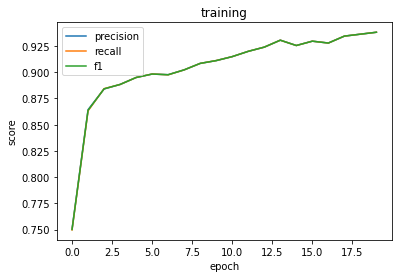

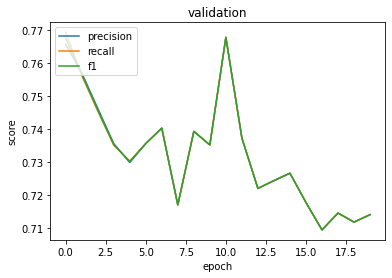

In [15]:
# Plot training accuracy
plt.plot(train_p)
plt.plot(train_r)
plt.plot(train_f)
plt.title('training')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(["precision", "recall", "f1"], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(val_p)
plt.plot(val_r)
plt.plot(val_f)
plt.title('validation')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(["precision", "recall", "f1"], loc='upper left')
plt.show()
